# Một mẫu ngẫu nhiên - Phân tích cận trên cho số láng giềng k (Upper Bound of k) dựa trên điểm tương đồng của k láng giềng gần nhất trong không gian Span Adaptation Vector.

## Mục đích

- Đánh giá xem nên chọn giá trị **k** (số láng giềng gần nhất trong k-NN) khoảng bao nhiêu là hợp lý.
- Dựa trên:
  - Điểm tương đồng (similarity score) có trọng số giữa một span test và các span train trong cơ sở dữ liệu.
  - Quan sát độ giảm dần của điểm tương đồng của láng giềng thứ k khi k tăng dần.
- Sử dụng:
  - Một mẫu span test ngẫu nhiên.
  - Các vector span train trong database đã xây dựng trước đó.
  - Trọng số lớp (layer weights) đã học sẵn.
- Kết quả:
  - Vẽ biểu đồ điểm tương đồng của láng giềng thứ k theo k (từ 1 đến `MAX_K_TO_TEST`).
  - Xác định một **“điểm gãy” (elbow)** mang tính heuristic, gợi ý cho cận trên hợp lý của k.


## Đầu vào

1. Cấu hình chung

   - Số lớp được dùng để matching:
     - `NUM_LAYERS_TO_MATCH = 12`
   - Số k tối đa cần khảo sát:
     - `MAX_K_TO_TEST = 100`
   - Thiết bị tính toán:
     ```python
     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     ```

2. Đường dẫn

   - `drive_base_path`  
     Thư mục gốc:
     - `/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep`

   - `output_dir`  
     Thư mục chứa kết quả:
     - `matching_results`

   - Trọng số lớp đã học:
     - `weights_file_path = matching_results/learned_layer_weights.pt`

   - Database vector train:
     - `db_cache_dir = cached_databases`
     - `db_vectors_file = cached_databases/combined_train_db_vectors.pt`
     - (Ở đây không dùng metadata, nên không cần tải `combined_train_db_metadata.json`)

   - Thư mục vector span test:
     - `test_span_av_dir = span_adaptation_vectors_test_gramvar`
     - Dùng tập Test_GramVar để chọn một span ngẫu nhiên.

3. Dữ liệu yêu cầu đã tồn tại trước

   - File trọng số đã học:
     - `learned_layer_weights.pt` (trọng số cho từng layer).
   - File database vector train:
     - `combined_train_db_vectors.pt` (tensor [N, 12, D]).
   - Các file `.pt` của span vector test (GramVar):
     - `span_adaptation_vectors_test_gramvar/<verb_name>/sentence_i_ARG_*.pt`

4. Thư viện sử dụng

   - `torch`, `torch.nn.functional as F`
   - `os`, `json`, `glob`, `random`, `re`
   - `tqdm.auto` (hiển thị tiến độ, chủ yếu cho log)
   - `matplotlib.pyplot` (vẽ biểu đồ)
   - `numpy` (tính sai phân, hỗ trợ tìm “elbow”)

## Đầu ra

1. Biểu đồ cận trên k

   - File ảnh:
     - `matching_results/k_upper_bound_analysis.png`
   - Nội dung:
     - Trục x: Giá trị k (1 → MAX_K_TO_TEST).
     - Trục y: Điểm tương đồng của láng giềng thứ k (sorted theo điểm giảm dần).
     - Đường đồ thị thể hiện sự suy giảm điểm tương đồng khi k tăng.
     - Một đường dọc (nếu tìm được “elbow”):
       - Gợi ý điểm gãy (k mà từ đó độ dốc giảm rõ rệt).

2. Log thông tin (in ra console)

   - Thông tin tải:
     - Đã tải DB với bao nhiêu span.
   - Tên file test được chọn ngẫu nhiên.
   - Thông báo nếu không tìm thấy file.
   - Giá trị “điểm gãy” ước lượng:
     - Ví dụ: `Điểm gãy (nơi đồ thị dốc nhất) được phát hiện vào khoảng k = 15`.
     - Hướng dẫn:
       - “Bạn nên chọn một giá trị k trước điểm này.”


## Quy trình

### 1. Tải trọng số và database

- Bước 1:
  - Tải:
    - `learned_weights` từ `weights_file_path`.
    - `train_db_vectors` từ `db_vectors_file`.
  - Chuyển `train_db_vectors` sang `device`:
    - `train_db_vectors.to(device)`.
  - Nếu thiếu file:
    - In lỗi và dừng chương trình.

### 2. Lấy mẫu test ngẫu nhiên

- Tìm tất cả file `.pt` trong:
  - `test_span_av_dir` (duyệt đệ quy).
- Chọn ngẫu nhiên một file:
  - `sample_test_file = random.choice(test_files)`.
- Đọc dữ liệu:
  - `layers_data = torch.load(sample_test_file)`.
- Lấy các vector của 12 layer:
  - `layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]`.
- Ghép thành một tensor:
  - `test_vector = torch.stack(layer_vectors).to(device)`  
  (shape: `[12, D]`).

### 3. Tính điểm tương đồng cho k láng giềng gần nhất

#### Hàm `find_k_nearest_neighbors_weighted(test_span_vectors, db_vectors, k, weights)`

- Mục đích:
  - Tính điểm tương đồng có trọng số giữa một span test và toàn bộ vector train, sau đó lấy ra top-k điểm lớn nhất.

- Các bước:
  1. Thêm chiều batch cho vector test:
     - `test_vectors_unsqueezed = test_span_vectors.unsqueeze(0)`  
       (shape: `[1, 12, D]`).
  2. Đảm bảo `weights` nằm trên cùng thiết bị với `db_vectors`:
     - `weights = weights.to(db_vectors.device)`.
  3. Tính cosine similarity theo từng lớp:
     - `similarities_per_layer = F.cosine_similarity(test_vectors_unsqueezed, db_vectors, dim=2)`  
       (shape: `[N, 12]`).
  4. Nhân với trọng số lớp:
     - `weighted_scores = torch.sum(similarities_per_layer * weights, dim=1)`  
       (shape: `[N]`).
  5. Lấy top-k:
     - `top_k_scores, top_k_indices = torch.topk(weighted_scores, k)`.
  6. Trả về:
     - `top_k_scores` và `top_k_indices`.

- Trong script:
  - Gọi hàm **một lần** với `k = MAX_K_TO_TEST`:
    - `all_k_scores, _ = find_k_nearest_neighbors_weighted(...)`.
  - Vì điểm trong `top_k` đã được sắp xếp giảm dần, nên:
    - Điểm của láng giềng thứ 1, 2, ..., k chính là:
      - `all_k_scores[0], all_k_scores[1], ..., all_k_scores[k-1]`.

### 4. Lưu điểm số của láng giềng thứ k

- Sau khi có `all_k_scores`:
  - Chuyển về numpy:
    - `kth_neighbor_scores = all_k_scores.cpu().numpy()`.
  - Đây là mảng có độ dài `MAX_K_TO_TEST`:
    - Mỗi phần tử là điểm tương đồng của láng giềng thứ k tương ứng.

### 5. Vẽ đồ thị k-th neighbor score theo k

- Tạo figure:
  - `plt.figure(figsize=(10, 6))`.
- Vẽ đường:
  - `plt.plot(range(1, MAX_K_TO_TEST + 1), kth_neighbor_scores, marker='o', linestyle='-')`.
- Thiết lập tiêu đề, nhãn:
  - `plt.title('Phân tích Chận Trên (Upper Bound) của k')`.
  - `plt.xlabel('Giá trị của k (k-th neighbor)')`.
  - `plt.ylabel('Điểm tương đồng (Similarity Score)')`.
- Thêm grid:
  - `plt.grid(True, linestyle='--', alpha=0.6)`.

### 6. Tìm “điểm gãy” (elbow) một cách heuristic

- Dùng sai phân bậc hai (xấp xỉ đạo hàm cấp 2 của chuỗi điểm):
  - `diffs = np.diff(kth_neighbor_scores, 2)`.
- Lấy vị trí có giá trị nhỏ nhất:
  - `elbow_k = np.argmin(diffs) + 2`  
    (cộng 2 do tính chất của `np.diff` 2 lần).
- Vẽ đường dọc tại `x = elbow_k`:
  - `plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Điểm gãy (Elbow) ~ k={elbow_k}')`.
- Gọi `plt.legend()`.
- In log:
  - Gợi ý:
    - “Bạn nên chọn một giá trị k trước điểm này.”

- Nếu có lỗi (ví dụ: dữ liệu không đủ để tính `np.diff` bậc 2):
  - In thông báo lỗi và bỏ qua việc vẽ đường elbow.

### 7. Lưu và hiển thị đồ thị

- Lưu file:
  - `plt.savefig(os.path.join(output_dir, 'k_upper_bound_analysis.png'))`.
- Hiển thị trên notebook:
  - `plt.show()`.
- In thông báo đường dẫn lưu:
  - `Đã lưu đồ thị vào: matching_results/k_upper_bound_analysis.png`.

Sử dụng thiết bị: cpu
--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---
 -> Tải thành công DB với 15521 span.

--- Bước 2: Lấy một mẫu test ngẫu nhiên ---
Đã chọn mẫu test: sentence_16_ARG_0.pt

--- Bước 3: Tính toán điểm tương đồng cho k từ 1 đến 100 ---

--- Bước 4: Vẽ đồ thị Similarity Variance ---

Điểm gãy (nơi đồ thị dốc nhất) được phát hiện vào khoảng k = 16
Bạn nên chọn một giá trị k trước điểm này.


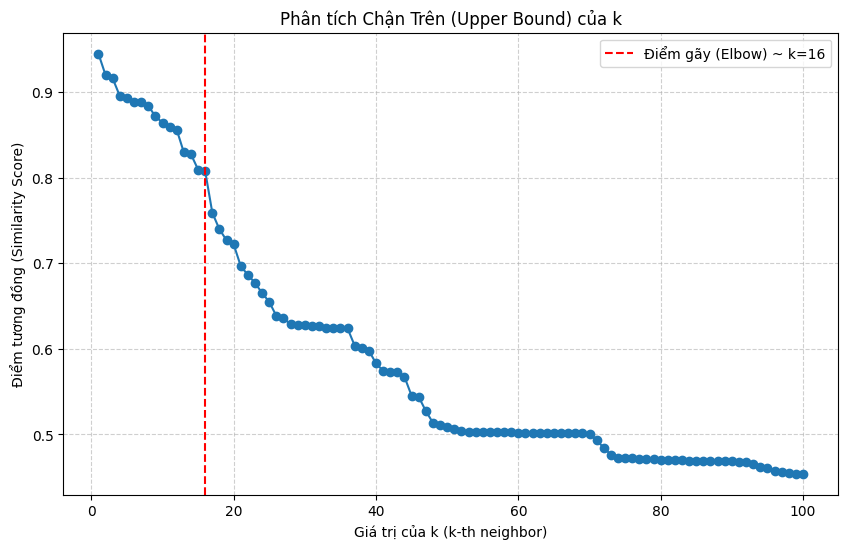


Đã lưu đồ thị vào: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/matching_results/k_upper_bound_analysis.png


In [ ]:
# Import các thư viện cần thiết
import torch
import os
import json
import glob
from tqdm.auto import tqdm
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt # Thư viện để vẽ đồ thị
import random
import numpy as np # *** THÊM DÒNG NÀY ĐỂ SỬA LỖI ***

# --- 1. CẤU HÌNH ---
NUM_LAYERS_TO_MATCH = 12
MAX_K_TO_TEST = 100 # Sẽ kiểm tra k từ 1 đến 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# --- 2. THIẾT LẬP CÁC ĐƯỜNG DẪN ---
drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'
output_dir = os.path.join(drive_base_path, 'matching_results')

# Đường dẫn đến file trọng số đã học
weights_file_path = os.path.join(output_dir, 'learned_layer_weights.pt')

# Đường dẫn đến database đã lưu
db_cache_dir = os.path.join(drive_base_path, 'cached_databases')
db_vectors_file = os.path.join(db_cache_dir, 'combined_train_db_vectors.pt')
db_metadata_file = os.path.join(db_cache_dir, 'combined_train_db_metadata.json')

# Dữ liệu Test (để lấy một mẫu ngẫu nhiên)
test_span_av_dir = os.path.join(drive_base_path, 'Span Adaptation Vector/Without Weight/Test_Content/span_adaptation_vectors_test_gramvar')

# --- 3. CÁC HÀM XỬ LÝ ---

def find_k_nearest_neighbors_weighted(test_span_vectors, db_vectors, k, weights):
    """Tìm kNN và trả về điểm số."""
    test_vectors_unsqueezed = test_span_vectors.unsqueeze(0)
    # Chuyển weights sang cùng thiết bị với db_vectors
    weights = weights.to(db_vectors.device)
    similarities_per_layer = F.cosine_similarity(test_vectors_unsqueezed, db_vectors, dim=2)
    weighted_scores = torch.sum(similarities_per_layer * weights, dim=1)
    # Tìm k điểm số cao nhất
    top_k_scores, top_k_indices = torch.topk(weighted_scores, k)
    return top_k_scores, top_k_indices

# --- 4. THỰC THI CHƯƠNG TRÌNH ---
if __name__ == "__main__":
    # --- Tải Trọng số và Database ---
    try:
        print("--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---")
        learned_weights = torch.load(weights_file_path, map_location=device)
        train_db_vectors = torch.load(db_vectors_file).to(device)
        print(f" -> Tải thành công DB với {train_db_vectors.shape[0]} span.")
    except FileNotFoundError as e:
        print(f"LỖI: Không tìm thấy file. Vui lòng chạy các bước trước. Lỗi: {e}")
        exit()

    # --- Lấy một mẫu Test ngẫu nhiên ---
    print("\n--- Bước 2: Lấy một mẫu test ngẫu nhiên ---")
    try:
        test_files = glob.glob(os.path.join(test_span_av_dir, '**', '*.pt'), recursive=True)
        if not test_files:
            print(f"LỖI: Không tìm thấy file .pt nào trong thư mục test: {test_span_av_dir}")
            exit()
        sample_test_file = random.choice(test_files)
        print(f"Đã chọn mẫu test: {os.path.basename(sample_test_file)}")

        layers_data = torch.load(sample_test_file, map_location='cpu')
        layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]
        test_vector = torch.stack(layer_vectors).to(device)
    except Exception as e:
        print(f"LỖI khi tải mẫu test: {e}")
        exit()

    # --- Bước 3: Tìm kNN và ghi lại điểm số của láng giềng thứ k ---
    print(f"\n--- Bước 3: Tính toán điểm tương đồng cho k từ 1 đến {MAX_K_TO_TEST} ---")
    kth_neighbor_scores = []

    # Tính toán một lần với k lớn nhất
    all_k_scores, _ = find_k_nearest_neighbors_weighted(
        test_vector, train_db_vectors, MAX_K_TO_TEST, learned_weights
    )

    # Lấy ra điểm số của láng giềng thứ k
    kth_neighbor_scores = all_k_scores.cpu().numpy()

    # --- Bước 4: Vẽ đồ thị ---
    print("\n--- Bước 4: Vẽ đồ thị Similarity Variance ---")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, MAX_K_TO_TEST + 1), kth_neighbor_scores, marker='o', linestyle='-')
    plt.title('Phân tích Chận Trên (Upper Bound) của k')
    plt.xlabel('Giá trị của k (k-th neighbor)')
    plt.ylabel('Điểm tương đồng (Similarity Score)')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Tìm "điểm gãy" (elbow) - một cách heuristic đơn giản
    try:
        # Tính đạo hàm cấp 2 (sự thay đổi của độ dốc)
        diffs = np.diff(kth_neighbor_scores, 2)
        elbow_k = np.argmin(diffs) + 2 # +2 vì diff
        plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Điểm gãy (Elbow) ~ k={elbow_k}')
        plt.legend()
        print(f"\nĐiểm gãy (nơi đồ thị dốc nhất) được phát hiện vào khoảng k = {elbow_k}")
        print("Bạn nên chọn một giá trị k trước điểm này.")
    except Exception as e:
        print(f"Không thể tự động tìm điểm gãy: {e}")

    plt.savefig(os.path.join(output_dir, 'k_upper_bound_analysis.png'))
    plt.show()

    print(f"\nĐã lưu đồ thị vào: {output_dir}/k_upper_bound_analysis.png")



# Một mẫu ngẫu nhiên - Đánh giá độ bền vững (Robustness) của kết quả k-NN khi thêm nhiễu vào vector span test trong không gian Span Adaptation Vector.


## Mục đích

- Kiểm tra **độ ổn định** (robustness) của tập láng giềng gần nhất k-NN khi:
  - Thay đổi nhẹ hoặc mạnh vector đầu vào (thêm nhiễu ngẫu nhiên).
- Trả lời câu hỏi:
  - Khi ta thêm nhiễu vào vector span test, các láng giềng gần nhất có thay đổi nhiều không?
  - Kết quả k-NN (với số k đã chọn) có đáng tin hay quá nhạy cảm với nhiễu?
- Kết quả:
  - Tính tỉ lệ chồng lặp (overlap) giữa tập láng giềng gốc và tập láng giềng sau khi thêm nhiễu.
  - Đưa ra kết luận định tính (thấp, trung bình, cao).


## Đầu vào

1. Cấu hình tham số

   - `K_TO_TEST`  
     Số láng giềng gần nhất cần kiểm tra (k trong k-NN).  
     Có thể thay đổi để thử các giá trị khác nhau, ví dụ:
     - `K_TO_TEST = 5` (trong code).

   - `NUM_LAYERS_TO_MATCH`  
     Số lớp được dùng trong việc tính similarity:
     - Mặc định: `12`.

   - `NOISE_LEVEL`  
     Độ lớn của nhiễu Gaussian thêm vào vector test:
     - Mặc định: `5` (tương đối lớn, cố ý để thử mức nhạy cảm).
     - Nhiễu được sinh bằng:
       - `noise = torch.randn_like(test_vector_original) * NOISE_LEVEL`.

   - `device`  
     Thiết bị sử dụng:
     - `cuda` nếu có GPU.
     - `cpu` nếu không có GPU.

2. Đường dẫn dữ liệu và mô hình

   - Gốc:
     - `drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'`.

   - Thư mục chứa kết quả matching:
     - `output_dir = os.path.join(drive_base_path, 'matching_results')`.

   - Trọng số lớp đã học:
     - `weights_file_path = os.path.join(output_dir, 'learned_layer_weights.pt')`.

   - Database vector train:
     - `db_cache_dir = os.path.join(drive_base_path, 'cached_databases')`.
     - `db_vectors_file = os.path.join(db_cache_dir, 'combined_train_db_vectors.pt')`.

   - Thư mục vector span test (dùng GramVar Test):
     - `test_span_av_dir = os.path.join(drive_base_path, 'span_adaptation_vectors_test_gramvar')`.

3. Điều kiện tiên quyết

   - Đã chạy các bước trước đó để tạo:
     - `learned_layer_weights.pt` (trọng số các layer).
     - `combined_train_db_vectors.pt` (tensor chứa toàn bộ span train).
     - Các file `.pt` span adaptation vectors cho test (GramVar).

4. Thư viện sử dụng

   - `torch`, `torch.nn.functional as F`
   - `os`, `json`, `glob`, `re`, `random`
   - `tqdm.auto.tqdm` để in log dạng thanh tiến độ (ở đây chủ yếu là log, không bắt buộc).

## Đầu ra

1. Thông tin in ra console

   - Thông tin tải dữ liệu:
     - Số lượng span trong DB train.
   - Thông tin mẫu test:
     - Tên file `.pt` được chọn ngẫu nhiên.
   - Kết quả k-NN trước và sau khi thêm nhiễu:
     - Tập chỉ số láng giềng gốc:
       - `set_original`.
     - Tập chỉ số láng giềng sau nhiễu:
       - `set_noised`.
   - Đánh giá định lượng:
     - `intersection_size`: số lượng láng giềng trùng nhau.
     - `overlap_percentage`: tỉ lệ trùng lặp:
       - `overlap_percentage = (intersection_size / K_TO_TEST) * 100`.

2. Kết luận định tính (dựa trên overlap)

   - Nếu `overlap_percentage < 50`:
     - Kết luận:
       - Tỉ lệ trùng lặp rất thấp.
       - Giá trị k này có thể quá nhỏ hoặc kết quả không ổn định.
   - Nếu `50 <= overlap_percentage < 80`:
     - Kết luận:
       - Tỉ lệ trùng lặp ở mức trung bình.
       - Có thể chấp nhận được, nhưng chưa thật sự rất ổn định.
   - Nếu `overlap_percentage >= 80`:
     - Kết luận:
       - Tỉ lệ trùng lặp cao.
       - Giá trị k này tốt và ổn định (robust) đối với mức nhiễu đã chọn.

## Quy trình

### Bước 1: Tải trọng số và database

- Đọc file:
  - `learned_weights = torch.load(weights_file_path, map_location=device)`.
  - `train_db_vectors = torch.load(db_vectors_file).to(device)`.
- Kiểm tra lỗi:
  - Nếu không tìm thấy file (FileNotFoundError):
    - In thông báo lỗi.
    - Thoát chương trình.

### Bước 2: Lấy một mẫu test ngẫu nhiên

1. Lấy danh sách file `.pt` trong:
   - `test_span_av_dir` (duyệt đệ quy với `glob`).
2. Nếu danh sách rỗng:
   - In lỗi và thoát.
3. Chọn ngẫu nhiên một file:
   - `sample_test_file = random.choice(test_files)`.
4. Tải dữ liệu từ file đó:
   - `layers_data = torch.load(sample_test_file, map_location='cpu')`.
5. Lấy vector của 12 layer:
   - `layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]`.
6. Ghép lại thành một tensor:
   - `test_vector_original = torch.stack(layer_vectors).to(device)`  
     (shape khoảng `[12, D]`).

### Bước 3: Tìm k láng giềng gần nhất cho mẫu gốc

#### Hàm `find_k_nearest_neighbors_weighted(test_span_vectors, db_vectors, k, weights)`

- Mục đích:
  - Tính k-NN với cosine similarity có trọng số theo layer.

- Các bước:
  1. Thêm chiều batch cho vector test:
     - `test_vectors_unsqueezed = test_span_vectors.unsqueeze(0)`  
       (shape: `[1, 12, D]`).
  2. Đưa `weights` về cùng device với `db_vectors`:
     - `weights = weights.to(db_vectors.device)`.
  3. Tính cosine similarity theo layer:
     - `similarities_per_layer = F.cosine_similarity(test_vectors_unsqueezed, db_vectors, dim=2)`  
       (shape: `[N, 12]`).
  4. Nhân với trọng số từng layer rồi cộng:
     - `weighted_scores = torch.sum(similarities_per_layer * weights, dim=1)`  
       (shape: `[N]`).
  5. Lấy top-k indices:
     - `_, top_k_indices = torch.topk(weighted_scores, k)`.
  6. Trả về:
     - `top_k_indices` (tensor chứa chỉ số các span train là láng giềng gần nhất).

- Áp dụng cho mẫu gốc:
  - `knn_original_indices = find_k_nearest_neighbors_weighted(test_vector_original, train_db_vectors, K_TO_TEST, learned_weights)`.
- Chuyển sang dạng set để tiện so sánh:
  - `set_original = set(knn_original_indices.cpu().numpy())`.

### Bước 4: Thêm nhiễu và tìm lại k-NN

1. Tạo vector nhiễu:
   - `noise = torch.randn_like(test_vector_original) * NOISE_LEVEL`.
2. Tạo vector test mới:
   - `test_vector_noised = test_vector_original + noise`.
3. Tìm k-NN trên vector nhiễu:
   - `knn_noised_indices = find_k_nearest_neighbors_weighted(test_vector_noised, train_db_vectors, K_TO_TEST, learned_weights)`.
4. Chuyển sang set:
   - `set_noised = set(knn_noised_indices.cpu().numpy())`.

### Bước 5: Đánh giá Robustness

1. Tính kích thước giao nhau giữa hai tập:
   - `intersection_size = len(set_original.intersection(set_noised))`.
2. Tính tỉ lệ trùng lặp:
   - `overlap_percentage = (intersection_size / K_TO_TEST) * 100`.
3. In thông tin:
   - Giá trị k đang kiểm tra.
   - Số láng giềng trùng nhau.
   - Tỉ lệ phần trăm trùng lặp.
4. Đưa ra kết luận bằng if–else dựa trên `overlap_percentage`:
   - Như phần “Đầu ra”.


In [ ]:
# Import các thư viện cần thiết
import torch
import os
import json
import glob
from tqdm.auto import tqdm
import torch.nn.functional as F
import re
import random

# --- 1. CẤU HÌNH ---
K_TO_TEST = 5
#-----------------------------------------

NUM_LAYERS_TO_MATCH = 12
NOISE_LEVEL = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# --- 2. THIẾT LẬP CÁC ĐƯỜNG DẪN ---
drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'
output_dir = os.path.join(drive_base_path, 'matching_results')

weights_file_path = os.path.join(output_dir, 'learned_layer_weights.pt')
db_cache_dir = os.path.join(drive_base_path, 'cached_databases')
db_vectors_file = os.path.join(db_cache_dir, 'combined_train_db_vectors.pt')
db_metadata_file = os.path.join(db_cache_dir, 'combined_train_db_metadata.json')
test_span_av_dir = os.path.join(drive_base_path, 'Span Adaptation Vector/Without Weight/Test_Content/span_adaptation_vectors_test_gramvar')

# --- 3. CÁC HÀM XỬ LÝ ---

def find_k_nearest_neighbors_weighted(test_span_vectors, db_vectors, k, weights):
    """Tìm kNN và chỉ trả về CHỈ SỐ (indices)."""
    test_vectors_unsqueezed = test_span_vectors.unsqueeze(0)
    # Chuyển weights sang cùng thiết bị
    weights = weights.to(db_vectors.device)
    similarities_per_layer = F.cosine_similarity(test_vectors_unsqueezed, db_vectors, dim=2)
    weighted_scores = torch.sum(similarities_per_layer * weights, dim=1)
    _, top_k_indices = torch.topk(weighted_scores, k)
    return top_k_indices

# --- 4. THỰC THI CHƯƠNG TRÌNH ---
if __name__ == "__main__":
    # --- Tải Trọng số và Database ---
    try:
        print("--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---")
        learned_weights = torch.load(weights_file_path, map_location=device)
        train_db_vectors = torch.load(db_vectors_file).to(device)
        print(f" -> Tải thành công DB với {train_db_vectors.shape[0]} span.")
    except FileNotFoundError as e:
        print(f"LỖI: Không tìm thấy file. Vui lòng chạy các bước trước. Lỗi: {e}")
        exit()

    # --- Lấy một mẫu Test ngẫu nhiên ---
    print("\n--- Bước 2: Lấy một mẫu test ngẫu nhiên ---")
    try:
        test_files = glob.glob(os.path.join(test_span_av_dir, '**', '*.pt'), recursive=True)
        if not test_files:
            print(f"LỖI: Không tìm thấy file .pt nào trong thư mục test: {test_span_av_dir}")
            exit()
        sample_test_file = random.choice(test_files)
        print(f"Đã chọn mẫu test: {os.path.basename(sample_test_file)}")

        layers_data = torch.load(sample_test_file, map_location='cpu')
        layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]
        test_vector_original = torch.stack(layer_vectors).to(device)
    except Exception as e:
        print(f"LỖI khi tải mẫu test: {e}")
        exit()

    # --- Bước 3: Tìm kNN cho mẫu GỐC ---
    print(f"\n--- Bước 3: Tìm {K_TO_TEST} láng giềng cho mẫu GỐC ---")
    knn_original_indices = find_k_nearest_neighbors_weighted(
        test_vector_original, train_db_vectors, K_TO_TEST, learned_weights
    )
    # Chuyển thành một set để dễ so sánh
    set_original = set(knn_original_indices.cpu().numpy())
    print(f" -> Các chỉ số láng giềng gốc: {set_original}")

    # --- Bước 4: Tạo nhiễu và tìm kNN cho mẫu MỚI ---
    print(f"\n--- Bước 4: Thêm nhiễu (noise level={NOISE_LEVEL}) và tìm lại láng giềng ---")
    # Tạo vector nhiễu có cùng kích thước và thêm vào
    noise = torch.randn_like(test_vector_original) * NOISE_LEVEL
    test_vector_noised = test_vector_original + noise

    knn_noised_indices = find_k_nearest_neighbors_weighted(
        test_vector_noised, train_db_vectors, K_TO_TEST, learned_weights
    )
    set_noised = set(knn_noised_indices.cpu().numpy())
    print(f" -> Các chỉ số láng giềng mới: {set_noised}")

    # --- Bước 5: So sánh và đánh giá ---
    print(f"\n--- Bước 5: Đánh giá độ bền vững (Robustness) ---")

    intersection_size = len(set_original.intersection(set_noised))
    overlap_percentage = (intersection_size / K_TO_TEST) * 100

    print(f"Giá trị k được kiểm tra: {K_TO_TEST}")
    print(f"Số láng giềng trùng lặp: {intersection_size}")
    print(f"Tỷ lệ trùng lặp: {overlap_percentage:.2f}%")

    if overlap_percentage < 50:
        print("\nKẾT LUẬN: Tỷ lệ trùng lặp RẤT THẤP. Giá trị k này có thể quá nhỏ và không ổn định.")
    elif overlap_percentage < 80:
        print("\nKẾT LUẬN: Tỷ lệ trùng lặp ở mức trung bình. Có thể chấp nhận được.")
    else:
        print("\nKẾT LUẬN: Tỷ lệ trùng lặp CAO. Giá trị k này là tốt và ổn định (robust).")



Sử dụng thiết bị: cpu
--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---
 -> Tải thành công DB với 15521 span.

--- Bước 2: Lấy một mẫu test ngẫu nhiên ---
Đã chọn mẫu test: sentence_13_ARG_4.pt

--- Bước 3: Tìm 5 láng giềng cho mẫu GỐC ---
 -> Các chỉ số láng giềng gốc: {np.int64(9665), np.int64(9667), np.int64(9669), np.int64(9673), np.int64(9661)}

--- Bước 4: Thêm nhiễu (noise level=20) và tìm lại láng giềng ---
 -> Các chỉ số láng giềng mới: {np.int64(9665), np.int64(9667), np.int64(9669), np.int64(9671), np.int64(9659)}

--- Bước 5: Đánh giá độ bền vững (Robustness) ---
Giá trị k được kiểm tra: 5
Số láng giềng trùng lặp: 3
Tỷ lệ trùng lặp: 60.00%

KẾT LUẬN: Tỷ lệ trùng lặp ở mức trung bình. Có thể chấp nhận được.


# Chọn nhiều mẫu ngẫu nhiên - Phân tích phân phối “điểm gãy” k (elbow k) trên nhiều mẫu test gộp (GramVar + ParaVE) để chọn cận trên hợp lý cho số láng giềng k trong k-NN.

## Mục đích

- Xác định **cận trên hợp lý cho k** (số láng giềng trong k-NN) không chỉ dựa trên một mẫu test đơn lẻ, mà dựa trên **nhiều mẫu test** được lấy ngẫu nhiên từ:
  - Tập test GramVar.
  - Tập test ParaVE.
- Với mỗi mẫu test:
  - Tính dãy điểm tương đồng của top-k láng giềng.
  - Suy ra một **“điểm gãy” k** (elbow) bằng heuristic.
- Trên toàn bộ mẫu:
  - Thống kê:
    - Giá trị trung bình (Mean), trung vị (Median), mode (giá trị k phổ biến nhất), min, max của “điểm gãy” k.
  - Vẽ histogram phân phối các “điểm gãy” k.
- Mục tiêu:
  - Gợi ý một vùng giá trị k hợp lý và ổn định cho các thí nghiệm k-NN ảnh hưởng (influence-based k-NN) tiếp theo.

## Đầu vào

### 1. Tham số cấu hình

- `NUM_LAYERS_TO_MATCH = 12`  
  Số lớp (layer) span adaptation vector dùng để tính similarity.

- `MAX_K_TO_TEST = 50`  
  Số k tối đa:
  - Sẽ tính điểm tương đồng cho các láng giềng từ 1 đến 50.

- `NUM_SAMPLES_TO_ANALYZE = 100`  
  Số lượng file test lấy mẫu ngẫu nhiên (tối đa):
  - Nếu tổng số file test nhiều hơn con số này:
    - Sẽ chọn ngẫu nhiên `NUM_SAMPLES_TO_ANALYZE` file.
  - Nếu ít hơn hoặc bằng:
    - Dùng tất cả.

- `device`  
  Thiết bị tính toán:
  - Tự động chọn `cuda` nếu có GPU, ngược lại dùng `cpu`.

### 2. Đường dẫn dữ liệu

- Gốc:
  - `drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'`.

- Thư mục kết quả:
  - `output_dir = os.path.join(drive_base_path, 'matching_results')`.

- Trọng số lớp đã học:
  - `weights_file_path = os.path.join(output_dir, 'learned_layer_weights.pt')`.

- Database span train:
  - `db_cache_dir = os.path.join(drive_base_path, 'cached_databases')`.
  - `db_vectors_file = os.path.join(db_cache_dir, 'combined_train_db_vectors.pt')`.

- Thư mục span test (gộp):
  - `test_span_av_dirs` là list gồm:
    - `span_adaptation_vectors_test_gramvar`
    - `span_adaptation_vectors_test_parave`

### 3. Dữ liệu yêu cầu đã được tạo trước

- File trọng số các layer:
  - `learned_layer_weights.pt`.
- File vector database train:
  - `combined_train_db_vectors.pt`.
- Các file `.pt` span adaptation vectors cho test:
  - Dưới dạng:
    - `span_adaptation_vectors_test_gramvar/<verb>/sentence_i_ARG_*.pt`
    - `span_adaptation_vectors_test_parave/<verb>/sentence_i_ARG_*.pt`

### 4. Thư viện sử dụng

- `torch`, `torch.nn.functional as F`
- `os`, `json`, `glob`, `random`, `re`
- `numpy as np`
- `matplotlib.pyplot as plt`
- `tqdm.auto.tqdm` (thanh tiến độ)
- `scipy.stats` (tính mode)

## Đầu ra

1. Thống kê “điểm gãy” k

   - Sau khi phân tích:
     - `mean_k`: k trung bình (Mean).
     - `median_k`: k trung vị (Median).
     - `mode_k`: k phổ biến nhất (Mode).
     - `min_k`: k nhỏ nhất.
     - `max_k`: k lớn nhất.
   - In trực tiếp ra console:
     - Số lượng mẫu test thực sự có tính được elbow.
     - Các giá trị thống kê nêu trên.

2. Biểu đồ phân phối “điểm gãy” k

   - File ảnh:
     - `matching_results/k_upper_bound_distribution_sampled_combined.png`
   - Nội dung biểu đồ:
     - Histogram phân phối các giá trị elbow k.
     - Hai đường dọc:
       - k trung bình (màu đỏ).
       - k trung vị (màu xanh lá).
     - Trục x:
       - Giá trị k (1 → MAX_K_TO_TEST).
     - Trục y:
       - Số lượng mẫu test có “điểm gãy” tại giá trị k tương ứng.

## Quy trình

### Bước 1: Tải trọng số và database train

- Tải:
  - `learned_weights = torch.load(weights_file_path, map_location=device)`.
  - `train_db_vectors = torch.load(db_vectors_file).to(device)`.
- Nếu không tìm thấy file:
  - In lỗi và dừng chương trình.

### Bước 2: Thu thập file test và lấy mẫu

1. Khởi tạo:
   - `test_files = []`.

2. Với mỗi thư mục trong `test_span_av_dirs`:
   - Dùng `glob.glob(..., recursive=True)` để lấy tất cả file `.pt`.
   - In số lượng file tìm được trong từng thư mục.
   - Thêm vào danh sách `test_files`.

3. Nếu `test_files` trống:
   - In lỗi và dừng chương trình.

4. Lấy mẫu:
   - Nếu `len(test_files) > NUM_SAMPLES_TO_ANALYZE`:
     - Dùng `random.sample` để chọn ra `NUM_SAMPLES_TO_ANALYZE` file.
   - Ngược lại:
     - Dùng toàn bộ `test_files`.

5. Chuẩn bị:
   - `all_elbow_ks = []` để lưu tất cả giá trị k tìm được từ nhiều mẫu.

### Bước 3: Tính dãy điểm tương đồng và “điểm gãy” cho từng mẫu

#### Hàm `find_k_nearest_neighbors_weighted(test_span_vectors, db_vectors, k, weights)`

- Mục đích:
  - Tính điểm tương đồng có trọng số giữa một vector test và database train, rồi lấy top-k điểm.

- Các bước:
  1. Thêm chiều batch:
     - `test_vectors_unsqueezed = test_span_vectors.unsqueeze(0)`.
  2. Đảm bảo `weights` trên cùng device:
     - `weights = weights.to(db_vectors.device)`.
  3. Tính cosine similarity theo layer:
     - `similarities_per_layer = F.cosine_similarity(test_vectors_unsqueezed, db_vectors, dim=2)`  
       (shape: `[N, 12]`).
  4. Nhân với trọng số từng layer rồi cộng:
     - `weighted_scores = torch.sum(similarities_per_layer * weights, dim=1)`  
       (shape: `[N]`).
  5. Lấy top-k:
     - `top_k_scores, _ = torch.topk(weighted_scores, k)`.
  6. Trả về `top_k_scores` (đã sắp giảm dần).

#### Hàm `find_elbow_k(scores_1d_array)`

- Mục đích:
  - Từ dãy điểm `scores_1d_array` (độ dài MAX_K_TO_TEST) tìm ra vị trí “gãy” k (elbow).

- Cách làm:
  1. Tính sai phân bậc hai:
     - `diffs = np.diff(scores_1d_array, 2)`.
  2. Tìm vị trí có giá trị nhỏ nhất:
     - `elbow_k = np.argmin(diffs) + 2` (cộng 2 vì sai phân bậc 2 làm ngắn mảng đi 2).
  3. Nếu lỗi:
     - Trả về `-1`.

#### Vòng lặp chính

- Với mỗi `test_file` trong `test_files_sample`:
  1. Tải dữ liệu:
     - `layers_data = torch.load(test_file, map_location='cpu')`.
  2. Kiểm tra đủ 12 layer:
     - Nếu thiếu, bỏ qua file.
  3. Lấy vector các layer:
     - `layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]`.
     - `test_vector = torch.stack(layer_vectors).to(device)`.
  4. Tính top-k similarity scores:
     - `all_k_scores = find_k_nearest_neighbors_weighted(test_vector, train_db_vectors, MAX_K_TO_TEST, learned_weights)`.
     - `kth_neighbor_scores = all_k_scores.cpu().numpy()`.
  5. Tìm elbow:
     - `elbow_k = find_elbow_k(kth_neighbor_scores)`.
     - Nếu `elbow_k > 0`:
       - Append vào `all_elbow_ks`.

- Có sử dụng `tqdm` để hiển thị tiến trình.

### Bước 4: Thống kê kết quả và vẽ histogram

1. Nếu `all_elbow_ks` rỗng:
   - In `"Không tìm thấy điểm gãy nào. Không thể thống kê."` và dừng.

2. Ngược lại:
   - Tính:
     - `mean_k = np.mean(all_elbow_ks)`.
     - `median_k = np.median(all_elbow_ks)`.
     - `mode_k = stats.mode(all_elbow_ks)[0]`.
     - `min_k = np.min(all_elbow_ks)`.
     - `max_k = np.max(all_elbow_ks)`.
   - In kết quả thống kê.

3. Vẽ histogram:
   - `plt.hist(all_elbow_ks, bins=range(1, MAX_K_TO_TEST + 1), edgecolor='black', alpha=0.7)`.
   - Tiêu đề:
     - `'Phân phối của "Điểm gãy" k (trên N mẫu test gộp)'`.
   - Trục x:
     - `'Giá trị "Điểm gãy" k'`.
   - Trục y:
     - `'Số lượng mẫu test'`.
   - Grid:
     - `plt.grid(True, linestyle='--', alpha=0.6)`.
   - Vẽ đường dọc:
     - `plt.axvline(x=mean_k, color='r', linestyle='--', label=f'k Trung bình ({mean_k:.2f})')`.
     - `plt.axvline(x=median_k, color='g', linestyle='--', label=f'k Trung vị ({median_k})')`.
   - Thêm legend và chỉnh ticks trục x:
     - `plt.xticks(range(0, MAX_K_TO_TEST + 1, 5))`.

4. Lưu và hiển thị:
   - `plt.savefig(os.path.join(output_dir, 'k_upper_bound_distribution_sampled_combined.png'))`.
   - `plt.show()`.
   - In thông báo đường dẫn file ảnh.


Sử dụng thiết bị: cpu
--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---
 -> Tải thành công DB với 15521 span.

--- Bước 2: Lấy 100 mẫu ngẫu nhiên từ 2 thư mục test ---
  Đang quét thư mục: span_adaptation_vectors_test_gramvar...
    -> Tìm thấy 1711 file.
  Đang quét thư mục: span_adaptation_vectors_test_parave...
    -> Tìm thấy 699 file.

Tổng cộng tìm thấy 2410 file, đang chọn ngẫu nhiên 100 file.


Phân tích tập Test (mẫu gộp):   0%|          | 0/100 [00:00<?, ?file/s]


--- Bước 3: Thống kê và Phân phối của các 'Điểm gãy' k ---
Đã phân tích 100 mẫu test.
  - k Trung bình (Mean):   13.40
  - k Trung vị (Median):  9.0
  - k Phổ biến nhất (Mode): 4
  - k Nhỏ nhất:             2
  - k Lớn nhất:             49


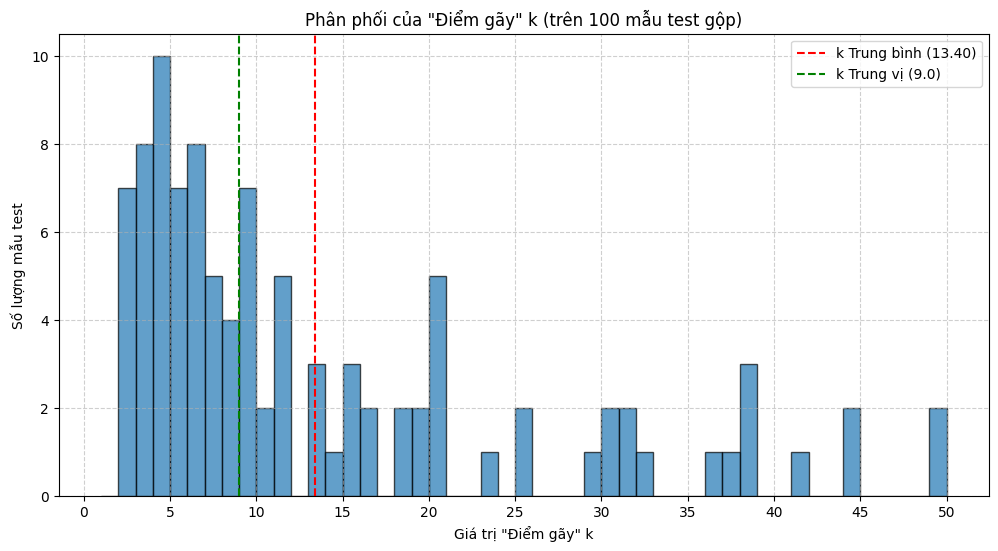


Đã lưu đồ thị phân phối vào: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/matching_results/k_upper_bound_distribution_sampled_combined.png


In [ ]:
# Import các thư viện cần thiết
import torch
import os
import json
import glob
from tqdm.auto import tqdm
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy import stats # Thêm thư viện stats để tìm mode

# --- 1. CẤU HÌNH ---
NUM_LAYERS_TO_MATCH = 12
MAX_K_TO_TEST = 50 # Sẽ kiểm tra k từ 1 đến 50
NUM_SAMPLES_TO_ANALYZE = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# --- 2. THIẾT LẬP CÁC ĐƯỜNG DẪN ---
drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'
output_dir = os.path.join(drive_base_path, 'matching_results')

weights_file_path = os.path.join(output_dir, 'learned_layer_weights.pt')

db_cache_dir = os.path.join(drive_base_path, 'cached_databases')
db_vectors_file = os.path.join(db_cache_dir, 'combined_train_db_vectors.pt')
db_metadata_file = os.path.join(db_cache_dir, 'combined_train_db_metadata.json')

# *** CẬP NHẬT: Dữ liệu Test (lấy từ cả GramVar và ParaVE) ***
test_span_av_dirs = [
    os.path.join(drive_base_path, 'Span Adaptation Vector/Without Weight/Test_Content/span_adaptation_vectors_test_gramvar'),
    os.path.join(drive_base_path, 'Span Adaptation Vector/Without Weight/Test_Content/span_adaptation_vectors_test_parave')
]

# --- 3. CÁC HÀM XỬ LÝ ---

def find_k_nearest_neighbors_weighted(test_span_vectors, db_vectors, k, weights):
    """Tìm kNN và trả về điểm số."""
    test_vectors_unsqueezed = test_span_vectors.unsqueeze(0)
    weights = weights.to(db_vectors.device)
    similarities_per_layer = F.cosine_similarity(test_vectors_unsqueezed, db_vectors, dim=2)
    weighted_scores = torch.sum(similarities_per_layer * weights, dim=1)
    top_k_scores, _ = torch.topk(weighted_scores, k)
    return top_k_scores

def find_elbow_k(scores_1d_array):
    """Tìm điểm gãy (elbow) từ một mảng điểm số."""
    try:
        diffs = np.diff(scores_1d_array, 2)
        elbow_k = np.argmin(diffs) + 2
        return elbow_k
    except Exception:
        return -1

# --- 4. THỰC THI CHƯƠNG TRÌNH ---
if __name__ == "__main__":
    # --- Tải Trọng số và Database ---
    try:
        print("--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---")
        learned_weights = torch.load(weights_file_path, map_location=device)
        train_db_vectors = torch.load(db_vectors_file).to(device)
        print(f" -> Tải thành công DB với {train_db_vectors.shape[0]} span.")
    except FileNotFoundError as e:
        print(f"LỖI: Không tìm thấy file. Vui lòng chạy các bước trước. Lỗi: {e}")
        exit()

    # --- Bước 2: Lấy một MẪU NGẪU NHIÊN từ TẤT CẢ tập test ---
    print(f"\n--- Bước 2: Lấy {NUM_SAMPLES_TO_ANALYZE} mẫu ngẫu nhiên từ {len(test_span_av_dirs)} thư mục test ---")

    # Lấy file từ TẤT CẢ các thư mục test
    test_files = []
    for test_dir in test_span_av_dirs:
        print(f"  Đang quét thư mục: {os.path.basename(test_dir)}...")
        files_in_dir = glob.glob(os.path.join(test_dir, '**', '*.pt'), recursive=True)
        test_files.extend(files_in_dir)
        print(f"    -> Tìm thấy {len(files_in_dir)} file.")

    if not test_files:
        print(f"LỖI: Không tìm thấy file .pt nào trong tất cả các thư mục test.")
        exit()

    # Lấy mẫu ngẫu nhiên từ danh sách gộp
    if len(test_files) > NUM_SAMPLES_TO_ANALYZE:
        print(f"\nTổng cộng tìm thấy {len(test_files)} file, đang chọn ngẫu nhiên {NUM_SAMPLES_TO_ANALYZE} file.")
        test_files_sample = random.sample(test_files, NUM_SAMPLES_TO_ANALYZE)
    else:
        print(f"\nTổng cộng tìm thấy {len(test_files)} file, sẽ sử dụng tất cả.")
        test_files_sample = test_files

    all_elbow_ks = [] # Danh sách để lưu tất cả các "điểm gãy"

    pbar = tqdm(total=len(test_files_sample), desc="Phân tích tập Test (mẫu gộp)", unit="file")

    for test_file in test_files_sample: # Lặp qua danh sách mẫu gộp
        try:
            layers_data = torch.load(test_file, map_location='cpu')
            # Kiểm tra xem file có đủ 12 lớp không
            if not all(f'layer_{j+1}' in layers_data for j in range(NUM_LAYERS_TO_MATCH)):
                pass # Bỏ qua file lỗi/thiếu lớp

            layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]
            test_vector = torch.stack(layer_vectors).to(device)

            all_k_scores = find_k_nearest_neighbors_weighted(
                test_vector, train_db_vectors, MAX_K_TO_TEST, learned_weights
            )

            kth_neighbor_scores = all_k_scores.cpu().numpy()

            elbow_k = find_elbow_k(kth_neighbor_scores)

            if elbow_k > 0:
                all_elbow_ks.append(elbow_k)

        except Exception as e:
            # Bỏ qua nếu có lỗi khi tải file
            pass
        pbar.update(1)

    pbar.close()

    # --- Bước 3: Thống kê và Vẽ đồ thị phân phối ---
    print("\n--- Bước 3: Thống kê và Phân phối của các 'Điểm gãy' k ---")

    if not all_elbow_ks:
        print("Không tìm thấy điểm gãy nào. Không thể thống kê.")
        exit()

    mean_k = np.mean(all_elbow_ks)
    median_k = np.median(all_elbow_ks)
    mode_k = stats.mode(all_elbow_ks)[0]
    min_k = np.min(all_elbow_ks)
    max_k = np.max(all_elbow_ks)

    print(f"Đã phân tích {len(all_elbow_ks)} mẫu test.")
    print(f"  - k Trung bình (Mean):   {mean_k:.2f}")
    print(f"  - k Trung vị (Median):  {median_k}")
    print(f"  - k Phổ biến nhất (Mode): {mode_k}")
    print(f"  - k Nhỏ nhất:             {min_k}")
    print(f"  - k Lớn nhất:             {max_k}")

    plt.figure(figsize=(12, 6))
    plt.hist(all_elbow_ks, bins=range(1, MAX_K_TO_TEST + 1), edgecolor='black', alpha=0.7)
    plt.title(f'Phân phối của "Điểm gãy" k (trên {len(all_elbow_ks)} mẫu test gộp)')
    plt.xlabel('Giá trị "Điểm gãy" k')
    plt.ylabel('Số lượng mẫu test')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axvline(x=mean_k, color='r', linestyle='--', label=f'k Trung bình ({mean_k:.2f})')
    plt.axvline(x=median_k, color='g', linestyle='--', label=f'k Trung vị ({median_k})')
    plt.legend()
    plt.xticks(range(0, MAX_K_TO_TEST + 1, 5))

    plt.savefig(os.path.join(output_dir, 'k_upper_bound_distribution_sampled_combined.png'))
    plt.show()

    print(f"\nĐã lưu đồ thị phân phối vào: {output_dir}/k_upper_bound_distribution_sampled_combined.png")



# Chọn nhiều mẫu ngẫu nhiên - Phân tích độ bền vững (Robustness) của k-NN theo nhiều giá trị k và mức nhiễu noise (Grid Search k–noise) bằng batch để tối ưu hiệu năng.

## Mục đích

- Đánh giá **độ ổn định** (robustness) của kết quả k-NN khi:
  - Thay đổi số láng giềng k.
  - Thêm nhiễu Gaussian với nhiều mức độ khác nhau vào span adaptation vector của mẫu test.
- Trả lời các câu hỏi:
  - Khi tăng noise, tập láng giềng gần nhất thay đổi mạnh hay vẫn ổn định?
  - Giá trị k nào ổn định hơn trước nhiễu?
  - Kết quả này có nhất quán trên nhiều mẫu test khác nhau hay không?
- Đầu ra:
  - Một **heatmap** thể hiện tỉ lệ trùng lặp trung bình giữa tập k-NN gốc và k-NN sau nhiễu, theo từng cặp (k, noise_level).
  - Bảng số liệu trung bình tỉ lệ trùng lặp cho tất cả (k, noise_level).

## Đầu vào

### 1. Tham số cấu hình

- `NUM_LAYERS_TO_MATCH = 12`  
  Số lớp (layer) được dùng trong span adaptation vector cho tính toán k-NN.

- `NUM_SAMPLES_TO_ANALYZE = 100`  
  Số lượng mẫu test ngẫu nhiên tối đa được sử dụng:
  - Nếu tổng số file test lớn hơn con số này:
    - Chọn ngẫu nhiên 100 file.
  - Nếu ít hơn:
    - Sử dụng toàn bộ.

- `K_RANGE = range(1, 11)`  
  Tập giá trị k cần phân tích:
  - k = 1, 2, 3, ..., 10.

- `NOISE_RANGE = range(0, 21, 1)`  
  Tập giá trị độ nhiễu (noise_level):
  - Từ 0 đến 20, bước 1.
  - `noise_level = 0` nghĩa là không thêm nhiễu (kết quả k-NN gốc).

- `BATCH_SIZE = 2`  
  Kích thước batch khi xử lý test vectors:
  - Giảm để tránh tràn bộ nhớ GPU.
  - Nếu vẫn lỗi, có thể giảm xuống 1.

- `device`  
  Thiết bị tính toán:
  - `cuda` nếu có GPU.
  - `cpu` nếu không có GPU.

### 2. Đường dẫn

- Thư mục gốc:
  - `drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'`.

- Thư mục kết quả:
  - `output_dir = os.path.join(drive_base_path, 'matching_results')`.

- Trọng số layer:
  - `weights_file_path = os.path.join(output_dir, 'learned_layer_weights.pt')`.

- Database train:
  - `db_cache_dir = os.path.join(drive_base_path, 'cached_databases')`.
  - `db_vectors_file = os.path.join(db_cache_dir, 'combined_train_db_vectors.pt')`.

- Thư mục span test (gộp):
  - `test_span_av_dirs` gồm:
    - `span_adaptation_vectors_test_gramvar`
    - `span_adaptation_vectors_test_parave`

### 3. Dữ liệu yêu cầu đã có sẵn

- File trọng số lớp:
  - `learned_layer_weights.pt` (trọng số đã học cho 12 layer).
- File vector train:
  - `combined_train_db_vectors.pt` (tensor [N, 12, D]).
- Các file `.pt` span adaptation vectors cho test:
  - Trong 2 thư mục:
    - `span_adaptation_vectors_test_gramvar/<verb>/sentence_i_ARG_*.pt`
    - `span_adaptation_vectors_test_parave/<verb>/sentence_i_ARG_*.pt`

### 4. Thư viện sử dụng

- Tính toán:
  - `torch`, `torch.nn.functional as F`
  - `numpy as np`
- Xử lý file và đường dẫn:
  - `os`, `glob`, `json`, `re`, `random`
- Hiển thị tiến độ:
  - `tqdm.auto.tqdm`
- Phân tích kết quả:
  - `pandas as pd`
- Vẽ biểu đồ:
  - `matplotlib.pyplot as plt`

## Đầu ra

1. Ma trận kết quả tỉ lệ trùng lặp

   - Biến `overlap_results` (numpy array) với shape:
     - `[num_test_samples, len(K_RANGE), len(NOISE_RANGE)]`.
   - Mỗi phần tử:
     - `overlap_results[sample_idx, k_idx, noise_idx]`:
       - Tỉ lệ phần trăm (%) trùng lặp giữa:
         - Tập k láng giềng gốc của mẫu test đó.
         - Tập k láng giềng sau khi thêm nhiễu `noise_level`.

2. Ma trận trung bình theo k và noise

   - Biến `mean_overlap`:
     - `mean_overlap = np.mean(overlap_results, axis=0)`  
       (trung bình trên trục mẫu test).
     - Shape: `[len(K_RANGE), len(NOISE_RANGE)]`.
   - DataFrame `heatmap_data`:
     - Index: các giá trị k.
     - Columns: các giá trị noise_level.
     - Giá trị: tỉ lệ trùng lặp trung bình (%).

3. Biểu đồ nhiệt (heatmap)

   - File output:
     - `matching_results/k_lower_bound_heatmap.png`.
   - Nội dung:
     - Trục x: mức độ nhiễu (noise_level).
     - Trục y: giá trị k.
     - Màu sắc:
       - Thể hiện tỉ lệ trùng lặp trung bình (%).
     - Hiển thị số trên từng ô (làm tròn 0 chữ số thập phân).

4. Bảng thống kê trung bình

   - In ra console `heatmap_data.to_string(...)`.
   - Cho phép quan sát trực tiếp tỉ lệ trùng lặp cho từng cặp (k, noise_level).

## Quy trình

### Bước 1: Tải trọng số và database

- Tải:
  - `learned_weights = torch.load(weights_file_path, map_location=device)`.
  - `train_db_vectors = torch.load(db_vectors_file).to(device)`.
- Nếu thiếu file:
  - Thông báo lỗi và dừng.

### Bước 2: Lấy và tải mẫu test

1. Thu thập tất cả file `.pt` trong hai thư mục test:
   - Dùng `glob.glob(..., recursive=True)` cho từng thư mục.
   - Gộp vào `test_files`.

2. Nếu `test_files` rỗng:
   - Báo lỗi và dừng.

3. Lấy mẫu ngẫu nhiên:
   - Nếu `len(test_files) > NUM_SAMPLES_TO_ANALYZE`:
     - `test_files_sample = random.sample(test_files, NUM_SAMPLES_TO_ANALYZE)`.
   - Nếu không:
     - Dùng toàn bộ.

4. Tải các mẫu test vào RAM:

   - Duyệt qua `test_files_sample`:
     - Với mỗi `test_file`:
       - `layers_data = torch.load(test_file, map_location='cpu')`.
       - Kiểm tra đủ 12 layer: `layer_1` đến `layer_12`.
       - Nếu đủ:
         - Lấy `layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]`.
         - Ghép thành tensor: `torch.stack(layer_vectors).to(device)`.
         - Append vào `test_vectors_list`.

   - Cuối cùng stack:
     - `test_vectors_batch = torch.stack(test_vectors_list)`  
       (shape: `[B, 12, D]`, với B là số mẫu hợp lệ).

### Bước 3: Hàm k-NN theo batch

#### Hàm `find_k_nearest_neighbors_weighted_batched(test_batch, db_vectors, k, weights)`

- Input:
  - `test_batch`: tensor `[B, 12, D]`.
  - `db_vectors`: tensor `[N, 12, D]`.
  - `weights`: tensor `[12]`.
  - `k`: số láng giềng cần lấy.

- Các bước:
  1. Đưa `weights` về cùng thiết bị với `db_vectors`.
  2. Mở rộng chiều cho phép broadcast:
     - `test_batch_exp = test_batch.unsqueeze(1)`  
       (shape: `[B, 1, 12, D]`).
     - `db_vectors_exp = db_vectors.unsqueeze(0)`  
       (shape: `[1, N, 12, D]`).
  3. Tính cosine similarity theo từng layer:
     - `similarities_per_layer = F.cosine_similarity(test_batch_exp, db_vectors_exp, dim=3)`  
       (shape: `[B, N, 12]`).
  4. Áp dụng trọng số layer:
     - `weighted_scores = torch.sum(similarities_per_layer * weights, dim=2)`  
       (shape: `[B, N]`).
  5. Lấy top-k:
     - `_, top_k_indices = torch.topk(weighted_scores, k, dim=1)`  
       (shape: `[B, k]`).
  6. Trả về:
     - `top_k_indices`: chỉ số các láng giềng k-NN cho từng mẫu trong batch.

### Bước 4: Grid Search trên (k, noise_level)

1. Khởi tạo:
   - `overlap_results = np.zeros((num_samples, len(K_RANGE), len(NOISE_RANGE)))`.

2. Vòng lặp theo k:

   - For mỗi `k` trong `K_RANGE`:
     - Khởi tạo `all_sets_original`:
       - List các tập chỉ số k-NN gốc cho từng mẫu test.

   - Chia các mẫu test thành mini-batch theo `BATCH_SIZE`:
     - For mỗi batch:
       - `current_batch = test_vectors_batch[batch_start:batch_end]`.

   3. Tính k-NN gốc cho batch:

      - `knn_original_batch = find_k_nearest_neighbors_weighted_batched(current_batch, train_db_vectors, k, learned_weights)`.
      - Với mỗi mẫu trong batch:
        - Lưu set chỉ số:
          - `all_sets_original[global_idx] = set(indices)`.

   4. Vòng lặp theo noise_level cho cùng batch:

      - For mỗi `noise_level` trong `NOISE_RANGE`:
        - Sinh nhiễu:
          - `noise = torch.randn_like(current_batch) * noise_level`.
        - Vector nhiễu:
          - `test_vectors_noised = current_batch + noise`.
        - Tính k-NN cho batch nhiễu:
          - `knn_noised_batch = find_k_nearest_neighbors_weighted_batched(test_vectors_noised, train_db_vectors, k, learned_weights)`.

        - Với từng mẫu trong batch:
          - Lấy set chỉ số mới: `set_noised`.
          - Tính giao với set gốc:
            - `intersection_size = len(all_sets_original[global_idx].intersection(set_noised))`.
          - Tính tỉ lệ trùng lặp:
            - `overlap_percentage = (intersection_size / k) * 100`.
          - Lưu vào `overlap_results[global_idx, k_idx, noise_idx]`.

3. Lặp cho mọi `k` và mọi `noise_level`.

### Bước 5: Thống kê và vẽ heatmap

1. Kiểm tra:
   - Nếu `overlap_results.size == 0`:
     - Báo lỗi và dừng.

2. Tính trung bình theo mẫu test:
   - `mean_overlap = np.mean(overlap_results, axis=0)`  
     (shape: `[len(K_RANGE), len(NOISE_RANGE)]`).

3. Tạo DataFrame:
   - `heatmap_data = pd.DataFrame(mean_overlap, index=list(K_RANGE), columns=list(NOISE_RANGE))`.

4. Vẽ heatmap:

   - Dùng `plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0, vmax=100)`.
   - Colorbar:
     - Nhãn: `Tỷ lệ trùng lặp trung bình (%)`.
   - Tiêu đề:
     - `Độ bền vững (Robustness) của k (Trung bình trên N mẫu)`.
   - Trục:
     - X: noise_level.
     - Y: k.
   - Ticks:
     - `plt.xticks(ticks=range(len(NOISE_RANGE)), labels=list(NOISE_RANGE))`.
     - `plt.yticks(ticks=range(len(K_RANGE)), labels=list(K_RANGE))`.
   - Ghi số lên từng ô:
     - Dùng `np.ndenumerate(heatmap_data.values)` và `plt.text(...)`.

5. Lưu biểu đồ:

   - `plt.savefig(os.path.join(output_dir, 'k_lower_bound_heatmap.png'))`.
   - `plt.show()`.

6. In bảng:

   - `print(heatmap_data.to_string(float_format="%.1f"))`.

Sử dụng thiết bị: cuda
--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---
 -> Tải thành công DB với 15521 span.

--- Bước 2: Lấy 100 mẫu test ngẫu nhiên ---
Đã chọn 100 mẫu test để phân tích.


Tải các mẫu test:   0%|          | 0/100 [00:00<?, ?it/s]

Đã tải thành công 100 mẫu test hợp lệ.

--- Bước 3: Bắt đầu Grid Search (Phiên bản Batched) ---


Đang xử lý K:   0%|          | 0/10 [00:00<?, ?it/s]

Xử lý batch (k=1):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=2):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=3):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=4):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=5):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=6):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=7):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=8):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=9):   0%|          | 0/50 [00:00<?, ?it/s]

Xử lý batch (k=10):   0%|          | 0/50 [00:00<?, ?it/s]

--- Thí nghiệm hoàn tất! ---

--- Bước 4: Tổng hợp kết quả và vẽ biểu đồ nhiệt ---


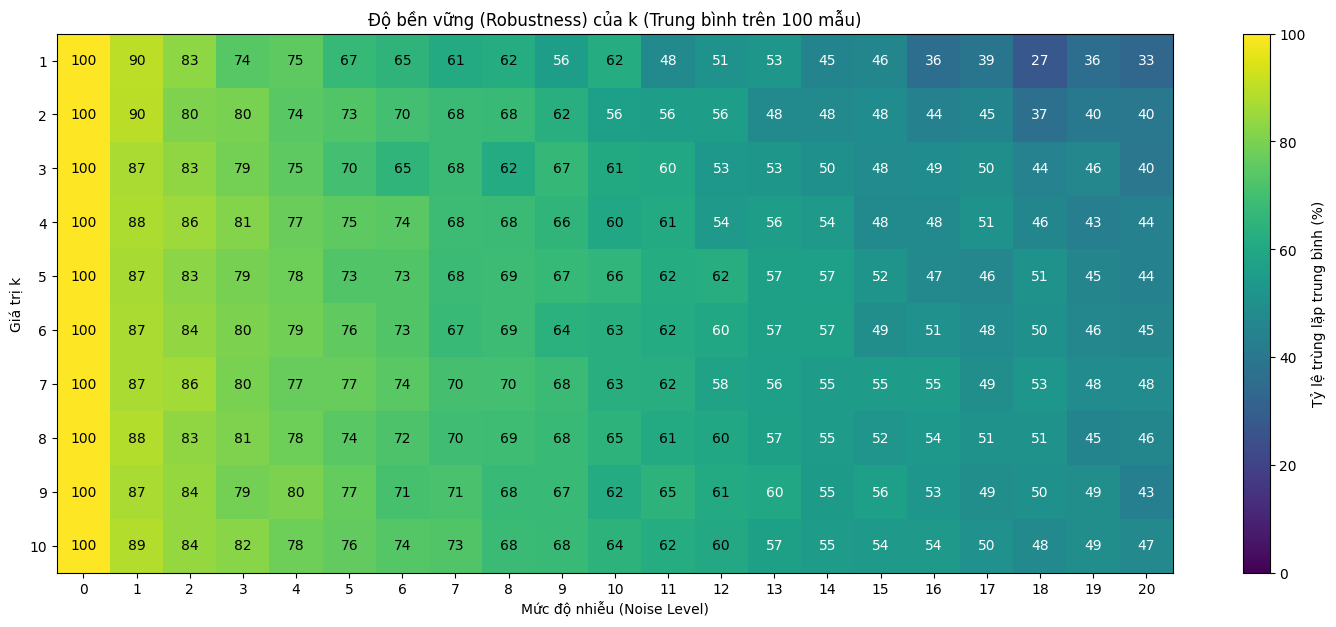


Đã lưu biểu đồ nhiệt vào: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/matching_results/k_lower_bound_heatmap.png

Bảng thống kê kết quả trung bình:
      0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20
1  100.0 90.0 83.0 74.0 75.0 67.0 65.0 61.0 62.0 56.0 62.0 48.0 51.0 53.0 45.0 46.0 36.0 39.0 27.0 36.0 33.0
2  100.0 89.5 80.5 80.0 74.5 73.0 70.0 68.0 67.5 62.5 56.5 56.0 55.5 48.0 47.5 48.5 44.0 45.0 37.0 40.5 40.0
3  100.0 87.3 83.3 79.0 75.0 70.0 65.3 68.0 61.7 66.7 60.7 59.7 53.3 53.0 50.3 48.3 48.7 49.7 44.3 46.3 39.7
4  100.0 87.8 85.5 81.2 77.0 75.2 74.5 68.5 68.0 65.5 60.0 61.2 54.0 56.0 54.0 48.0 48.0 51.2 45.8 42.8 44.0
5  100.0 87.0 82.6 79.4 78.0 73.0 72.8 68.2 68.6 66.8 65.8 61.8 62.2 56.8 56.6 51.6 47.0 46.2 51.0 45.4 44.0
6  100.0 87.2 83.7 80.2 78.7 75.7 72.7 67.3 68.7 64.0 62.8 61.7 60.0 56.7 56.8 49.3 50.7 48.2 50.3 46.2 45.5
7  100.0 87.3 86.3 80.0 76.9 76.6 74.4 70.4 70.0 68.0 63.0 62.1 57.7 56.

In [ ]:
# Import các thư viện cần thiết
import torch
import os
import json
import glob
from tqdm.auto import tqdm
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd # Dùng để phân tích kết quả

# --- 1. CẤU HÌNH ---
NUM_LAYERS_TO_MATCH = 12
# --- Cấu hình thí nghiệm ---
NUM_SAMPLES_TO_ANALYZE = 100       # Số lượng mẫu test ngẫu nhiên để phân tích
K_RANGE = range(1, 11)           # k chạy từ 1 đến 10
NOISE_RANGE = range(0, 21, 1)    # noise_level chạy từ 0 đến 20, bước nhảy 1
BATCH_SIZE = 2
# ------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# --- 2. THIẾT LẬP CÁC ĐƯỜNG DẪN ---
drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep'
output_dir = os.path.join(drive_base_path, 'matching_results')

weights_file_path = os.path.join(output_dir, 'learned_layer_weights.pt')
db_cache_dir = os.path.join(drive_base_path, 'cached_databases')
db_vectors_file = os.path.join(db_cache_dir, 'combined_train_db_vectors.pt')
db_metadata_file = os.path.join(db_cache_dir, 'combined_train_db_metadata.json')

test_span_av_dirs = [
    os.path.join(drive_base_path, 'Span Adaptation Vector/Without Weight/Test_Content/span_adaptation_vectors_test_gramvar'),
    os.path.join(drive_base_path, 'Span Adaptation Vector/Without Weight/Test_Content/span_adaptation_vectors_test_parave')
]

# --- 3. CÁC HÀM XỬ LÝ ---

def find_k_nearest_neighbors_weighted_batched(test_batch, db_vectors, k, weights):
    """
    Tìm kNN cho một BATCH các vector test.
    test_batch: [B, 12, 2304] (B là số lượng mẫu test, ví dụ: 2)
    db_vectors: [N, 12, 2304] (N là số lượng mẫu train trong DB)
    weights: [12]
    """
    weights = weights.to(db_vectors.device)

    test_batch_exp = test_batch.unsqueeze(1)
    db_vectors_exp = db_vectors.unsqueeze(0)

    # Phép tính này bây giờ sẽ nhỏ hơn nhiều (ví dụ: [2, 15521, 12])
    similarities_per_layer = F.cosine_similarity(test_batch_exp, db_vectors_exp, dim=3)

    weighted_scores = torch.sum(similarities_per_layer * weights, dim=2)

    _, top_k_indices = torch.topk(weighted_scores, k, dim=1)

    return top_k_indices

# --- 4. THỰC THI CHƯƠNG TRÌNH ---
if __name__ == "__main__":
    # --- Tải Trọng số và Database ---
    try:
        print("--- Bước 1: Tải trọng số và cơ sở dữ liệu Train ---")
        learned_weights = torch.load(weights_file_path, map_location=device)
        train_db_vectors = torch.load(db_vectors_file).to(device)
        print(f" -> Tải thành công DB với {train_db_vectors.shape[0]} span.")
    except FileNotFoundError as e:
        print(f"LỖI: Không tìm thấy file. Vui lòng chạy các bước trước. Lỗi: {e}")
        exit()

    # --- Lấy mẫu Test ngẫu nhiên ---
    print(f"\n--- Bước 2: Lấy {NUM_SAMPLES_TO_ANALYZE} mẫu test ngẫu nhiên ---")
    test_files = []
    for test_dir in test_span_av_dirs:
        files_in_dir = glob.glob(os.path.join(test_dir, '**', '*.pt'), recursive=True)
        test_files.extend(files_in_dir)

    if not test_files:
        print(f"LỖI: Không tìm thấy file .pt nào trong thư mục test.")
        exit()

    if len(test_files) > NUM_SAMPLES_TO_ANALYZE:
        test_files_sample = random.sample(test_files, NUM_SAMPLES_TO_ANALYZE)
    else:
        test_files_sample = test_files
    print(f"Đã chọn {len(test_files_sample)} mẫu test để phân tích.")

    # Tải trước các mẫu test vào RAM
    test_vectors_list = []
    for test_file in tqdm(test_files_sample, desc="Tải các mẫu test"):
        try:
            layers_data = torch.load(test_file, map_location='cpu')
            if all(f'layer_{j+1}' in layers_data for j in range(NUM_LAYERS_TO_MATCH)):
                layer_vectors = [layers_data[f'layer_{j+1}'] for j in range(NUM_LAYERS_TO_MATCH)]
                test_vectors_list.append(torch.stack(layer_vectors).to(device))
        except Exception:
            pass

    test_vectors_batch = torch.stack(test_vectors_list) # Shape: [100, 12, 2304]
    print(f"Đã tải thành công {test_vectors_batch.shape[0]} mẫu test hợp lệ.")

    # --- Bước 3: Chạy thí nghiệm Grid Search ---
    print(f"\n--- Bước 3: Bắt đầu Grid Search (Phiên bản Batched) ---")

    overlap_results = np.zeros((len(test_vectors_list), len(K_RANGE), len(NOISE_RANGE)))

    # Vòng lặp ngoài cùng là k
    for k_idx, k in enumerate(tqdm(K_RANGE, desc="Đang xử lý K")):

        # Tạo hai mảng lớn để lưu kết quả trung gian
        all_sets_original = [set() for _ in range(len(test_vectors_list))]

        # Thêm vòng lặp mini-batch
        for batch_start in tqdm(range(0, len(test_vectors_list), BATCH_SIZE), desc=f"Xử lý batch (k={k})", leave=False):
            batch_end = batch_start + BATCH_SIZE
            current_batch = test_vectors_batch[batch_start:batch_end] # [B, 12, 2304]

            # Tìm kNN cho BATCH GỐC
            knn_original_batch = find_k_nearest_neighbors_weighted_batched(
                current_batch, train_db_vectors, k, learned_weights
            ) # Shape: [B, k]

            # Lưu kết quả gốc
            for i, indices in enumerate(knn_original_batch.cpu().numpy()):
                all_sets_original[batch_start + i] = set(indices)

            # Vòng lặp thứ hai là noise (xử lý trên cùng batch này)
            for noise_idx, noise_level in enumerate(NOISE_RANGE):
                noise = torch.randn_like(current_batch) * noise_level
                test_vectors_noised = current_batch + noise

                knn_noised_batch = find_k_nearest_neighbors_weighted_batched(
                    test_vectors_noised, train_db_vectors, k, learned_weights
                ) # Shape: [B, k]

                # So sánh và lưu kết quả
                for i in range(len(current_batch)): # Lặp qua các mẫu trong batch (B)
                    global_idx = batch_start + i
                    set_noised = set(knn_noised_batch[i].cpu().numpy())
                    intersection_size = len(all_sets_original[global_idx].intersection(set_noised))
                    overlap_percentage = (intersection_size / k) * 100
                    overlap_results[global_idx, k_idx, noise_idx] = overlap_percentage

    print("--- Thí nghiệm hoàn tất! ---")

    # --- Bước 4: Thống kê và Vẽ đồ thị ---
    print("\n--- Bước 4: Tổng hợp kết quả và vẽ biểu đồ nhiệt ---")

    if overlap_results.size == 0:
        print("LỖI: Không có kết quả nào được ghi lại.")
        exit()

    # Tính trung bình trên 100 mẫu test (trục 0)
    mean_overlap = np.mean(overlap_results, axis=0) # Shape: [10, 21]

    # Tạo bảng pivot
    heatmap_data = pd.DataFrame(
        mean_overlap,
        index=list(K_RANGE),
        columns=list(NOISE_RANGE)
    )

    # Vẽ heatmap
    plt.figure(figsize=(18, 7))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0, vmax=100)

    plt.colorbar(label='Tỷ lệ trùng lặp trung bình (%)')
    plt.title(f'Độ bền vững (Robustness) của k (Trung bình trên {len(test_vectors_list)} mẫu)')
    plt.xlabel('Mức độ nhiễu (Noise Level)')
    plt.ylabel('Giá trị k')

    plt.xticks(ticks=range(len(NOISE_RANGE)), labels=list(NOISE_RANGE))
    plt.yticks(ticks=range(len(K_RANGE)), labels=list(K_RANGE))

    for (j, i), label in np.ndenumerate(heatmap_data.values):
        plt.text(i, j, f'{label:.0f}', ha='center', va='center', color='white' if label < 60 else 'black')

    plt.savefig(os.path.join(output_dir, 'k_lower_bound_heatmap.png'))
    plt.show()

    print(f"\nĐã lưu biểu đồ nhiệt vào: {output_dir}/k_lower_bound_heatmap.png")

    print("\nBảng thống kê kết quả trung bình:")
    print(heatmap_data.to_string(float_format="%.1f"))

